In [18]:
from jax import config
config.update("jax_enable_x64", True)
from dataclasses import dataclass

from jax import jit
from jax.config import config
import jax.numpy as jnp
from jax.lax import erf
import jax.random as jr
from typing import List, Union, Callable
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
)
import itertools
from jax import vmap
from gpjax.kernels import ProductKernel
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd
from tensorflow_probability.substrates.jax.mcmc import sample_halton_sequence 
from matplotlib import rcParams
from gpjax.base import param_field, static_field
import matplotlib.pyplot as plt
import optax as ox
import warnings
import pandas as pd
import tensorflow_probability as tfp
from jaxtyping import Float, Num
import cola
from cola.linalg.decompositions.decompositions import Cholesky
from gpjax.typing import (
    Array,
    ScalarInt,
    ScalarFloat,
)
from gpjax.kernels.stationary.utils import squared_distance
from gpjax.kernels import Constant, RBF
from gpjax.dataset import Dataset
from gpjax.distributions import GaussianDistribution
with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
key = jr.PRNGKey(12345)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
colors = rcParams["axes.prop_cycle"].by_key()["color"]


/tmp/ipykernel_110576/2584348870.py:6: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


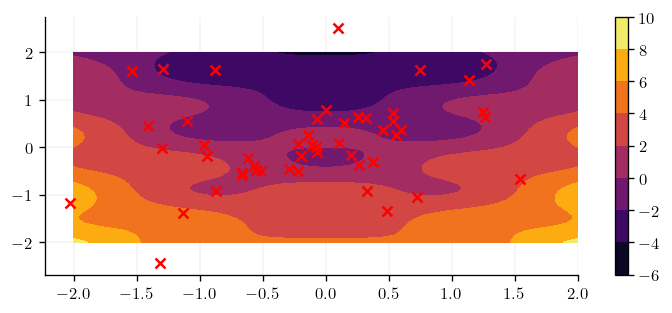

In [2]:
n = 50
d=2
noise = 0.01
# key, subkey = jr.split(key)


x = jr.normal(key=key, shape=(n,d)) 
#x = jr.uniform(key=key, shape=(n,d), minval=-2, maxval=2)

def f(x):
    x_1 = x[:,0:1]
    x_2 = x[:,1:2]
    return (x_1**2 - 2*x_2 + jnp.cos(3*x_1)*jnp.sin(5*x_2))

signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise
D = gpx.Dataset(X=x, y=y)


n_plot = 50
X, Y = jnp.meshgrid(jnp.linspace(-2,2,n_plot), jnp.linspace(-2,2,n_plot))
xplot2d = jnp.stack([X.reshape(-1), Y.reshape(-1)]).T
xplot1d = jr.uniform(key, shape=(n_plot,1), minval=-2, maxval=2)
def plot(Z):
    Z = Z.reshape(n_plot, n_plot)
    cp = plt.contourf(X, Y, Z)
    plt.colorbar(cp)


plot(f(xplot2d))
plt.scatter(x[:,0], x[:,1], c="red", marker="x")


Optimization terminated successfully.
         Current function value: 17.583778
         Iterations: 22
         Function evaluations: 70
         Gradient evaluations: 68
variances are 8.231634476541979
lengthscaels are [0.74463483 0.4944019 ]


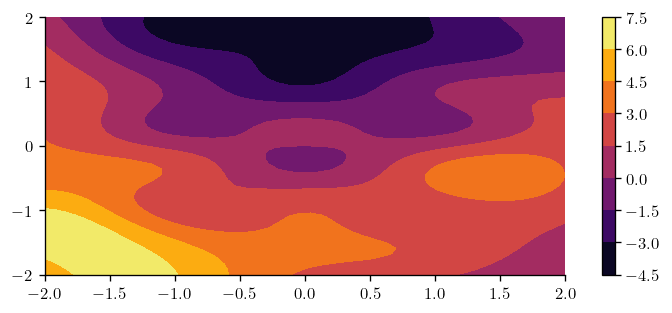

In [3]:
kernel = gpx.kernels.RBF(lengthscale=jnp.array([0.1, 0.1]))
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=noise)#.replace_trainable(obs_noise=False)
posterior = prior * likelihood

opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=jit(gpx.objectives.ConjugateMLL(negative=True)),
    train_data=D,
)
print(f"variances are {opt_posterior.prior.kernel.variance}")
print(f"lengthscaels are {opt_posterior.prior.kernel.lengthscale}")
plt.figure()

plot(opt_posterior.predict(xplot2d, D).mean())

In [7]:
@dataclass()
class OrthogonalRBF(gpx.kernels.AbstractKernel):
    r"""todo only for unit gaussian input measure and zero mean."""
    name: str = "OrthogonalRBF"
    lengthscale: Union[ScalarFloat, Float[Array, " D"]] = param_field(
        jnp.array(1.0), bijector=tfb.Softplus()
    )

    def __post_init__(self):
        warnings.warn("This kernel is only valid for unit gaussian input measures and zero mean functions.")

    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute an orthogonal RBF kernel between a pair of arrays."""
        x = self.slice_input(x) # [d]
        y = self.slice_input(y) # [d]
        ks = jnp.exp(-0.5 * ((x - y) / self.lengthscale) ** 2) # [d]
        ks -=  self._cov_x_s(x) * self._cov_x_s(y) / self._var_s() # [d]
        return jnp.prod(ks)
    
    def _cov_x_s(self,x):
        l2 = self.lengthscale ** 2
        return jnp.sqrt(l2 / (l2 + 1.0)) * jnp.exp(-0.5 * (x ** 2) / (l2 + 1.0)) # [d]
        
    def _var_s(self):
        return  jnp.sqrt(self.lengthscale ** 2 / (self.lengthscale ** 2 + 2.0)) # [d]


@dataclass()
class AdditiveKernel(gpx.kernels.AbstractKernel):
    r"""An Additive Kernel ."""
    kernels: list[RBF] = None
    # jax/jit requires specifying max_interaction depth even though this could be infered from length of interaction_variances
    max_interaction_depth: ScalarInt = static_field(1)
    interaction_variances: Float[Array, " p"] = param_field(jnp.array([1.0, 1.0]), bijector=tfb.Softplus())
    max_interaction_depth: ScalarInt = static_field(1)
    name: str = "AdditiveKernel"

    def __post_init__(self):
        assert self.max_interaction_depth == len(self.interaction_variances) - 1, "Number of interaction variances must be equal to max_interaction_depth + 1"


    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute the additive kernel between a pair of arrays."""
        x = self.slice_input(x) # [d]
        y = self.slice_input(y) # [d]
        ks = jnp.stack([k(x,y) for k in self.kernels])
        return jnp.dot(self._compute_additive_terms_girad_newton(ks), self.interaction_variances)
            
    @jit   
    def _compute_additive_terms_girad_newton(self, ks: Num[Array, " D"]) -> ScalarFloat:
        r"""Given a list of inputs, compute a new list containing all products up to order
        `max_interaction_depth`. For efficiency, we us the Girad Newton identity 
        (i.e. O(d^2) instead of exponential).
        """
        powers = jnp.arange(self.max_interaction_depth + 1)[:, None] # [p + 1, 1]
        s = jnp.power(ks[None, :],powers) # [p+1, d]
        e = jnp.ones(shape=(self.max_interaction_depth+1), dtype=jnp.float64) # lazy init then populate
        for n in range(1, self.max_interaction_depth + 1): # has to be for loop because iterative
            thing = vmap(lambda k: ((-1.0)**(k-1))*e[n-k]*s[k, :])(jnp.arange(1, n+1))
            e = e.at[n].set((1.0/n) *jnp.sum(thing))
        return jnp.array(e) # [max_interaction_depth + 1]
    

    def get_specific_kernel(self, component_list: List[int] = []) -> gpx.kernels.AbstractKernel:
        r"""todo"""
        var = self.interaction_variances[len(component_list)]
        kernel = Constant(constant = var)
        for i in component_list:
            kernel = kernel * self.kernels[i]
        return kernel





In [8]:
class AdditivePosterior(gpx.gps.ConjugatePosterior):
    r"""todo"""
    def __post__init__(self):
        
        assert isinstance(self.prior.kernel, AdditiveKernel), "OAK only works with AdditiveKernel kernel"
        if jnp.any([isinstance(k, OrthogonalRBF) for k in self.prior.kernel.kernels]):
            assert isinstance(self.prior.mean_function, gpjax.mean_functions.Zero), "Orthogonal kernels assume zero mean functions"
        

    def predict_additive_component(
        self,
        test_inputs: Num[Array, "N D"],
        train_data: Dataset,
        component_list: List[List[int]]
    ) -> GaussianDistribution:

        specific_kernel = self.prior.kernel.get_specific_kernel(component_list)
        Kxx = self.prior.kernel.gram(train_data.X)
        Kxt = specific_kernel.cross_covariance(train_data.X, test_inputs)
        Sigma = cola.PSD(Kxx + cola.ops.I_like(Kxx) * self.likelihood.obs_stddev**2)
        Sigma_inv_Kxt = cola.solve(Sigma, Kxt)
        mean =  jnp.matmul(Sigma_inv_Kxt.T, train_data.y)
        covariance = specific_kernel.gram(test_inputs) - jnp.matmul(Kxt.T, Sigma_inv_Kxt)
        return GaussianDistribution(jnp.atleast_1d(mean.squeeze()), cola.PSD(covariance))




    def get_all_sobols(self, train_data: Dataset) -> List[ScalarFloat]:
        """ approx """
        individual_Kxxs = [k.gram(train_data.X).to_dense() for k in self.prior.kernel.orthogonal_kernels]
        all_possible_Kxxs = []
        for i in range(1, self.prior.kernel.max_interaction_depth + 1):
            for comb in itertools.combinations(range(len(self.prior.kernel.orthogonal_kernels)), i):
                current = individual_Kxxs[comb[0]]
                for k in comb[1:]:
                    current*= individual_Kxxs[k]
                all_possible_Kxxs.append(current*self.prior.kernel.interaction_variances[i])
        all_possible_Kxxs = jnp.stack(all_possible_Kxxs) # [D, N, N]
        Kxx = self.prior.kernel.gram(train_data.X) # [N, N]
        Sigma = cola.PSD(Kxx + cola.ops.I_like(Kxx) * self.likelihood.obs_stddev**2)
        Sigma_inv_y = cola.solve(Sigma, train_data.y)[None, :, :] # [1, N, 1]
        predicted_means = jnp.matmul(all_possible_Kxxs, Sigma_inv_y).squeeze() # [D, N, 1]
        all_sobols =  jnp.var(predicted_means, axis=1) / jnp.var(self.predict(D.X, D).mean()) # [D, 1]
        return all_sobols
    

    def get_sobol_index(self, train_data: Dataset, component_list: List[int]) -> ScalarFloat:
        """ approx """
        component_posterior = self.predict_additive_component(train_data.X, train_data, component_list)
        full_posterior= self.predict(train_data.X, train_data)
        return jnp.var(component_posterior.mean()) / jnp.var(full_posterior.mean())



Optimization terminated successfully.
         Current function value: 110.280076
         Iterations: 33
         Function evaluations: 49
         Gradient evaluations: 49


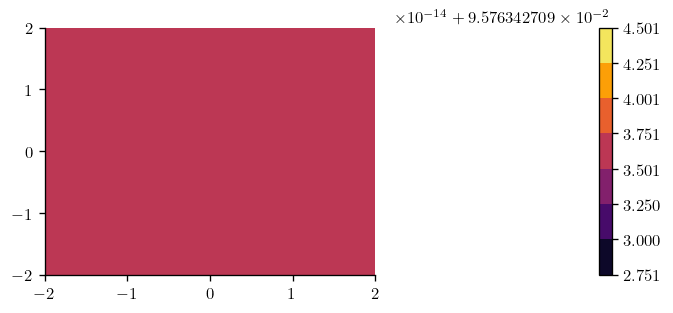

In [9]:
kernel = AdditiveKernel(
    kernels=[OrthogonalRBF(active_dims=[0]), OrthogonalRBF(active_dims=[1])],
    interaction_variances=jnp.array([1.]), 
    max_interaction_depth=0, 
    )
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=noise)#.replace_trainable(obs_noise=False)
posterior = AdditivePosterior(prior =prior, likelihood=likelihood)

opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=gpx.objectives.ConjugateLOOCV(negative=True),
    train_data=D,
)

plot(opt_posterior.predict(xplot2d, D).mean())

Optimization terminated successfully.
         Current function value: 67.154252
         Iterations: 45
         Function evaluations: 72
         Gradient evaluations: 72
variances are [0.36645464 3.57084829]
lengthscaels are [Array(0.11798289, dtype=float64), Array(1.23606913, dtype=float64)]


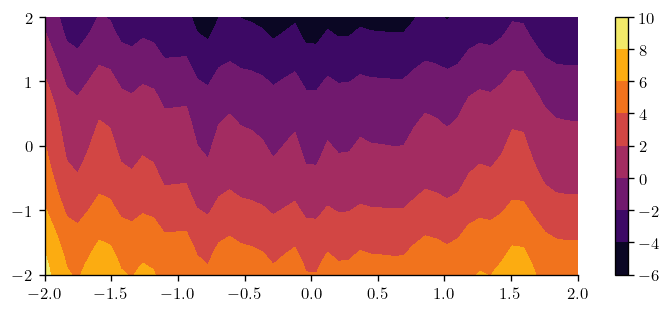

In [10]:
kernel = AdditiveKernel(
    kernels=[OrthogonalRBF(active_dims=[0], lengthscale=jnp.array(0.1)), OrthogonalRBF(active_dims=[1], lengthscale=jnp.array(0.1))],
    interaction_variances=jnp.array([1.0,1.0]), 
    max_interaction_depth=1, 
    )
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=noise)#.replace_trainable(obs_stddev=False)
posterior = AdditivePosterior(prior =prior, likelihood=likelihood)

opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=gpx.objectives.ConjugateMLL(negative=True),
    train_data=D,
)
print(f"variances are {opt_posterior.prior.kernel.interaction_variances}")
print(f"lengthscaels are {[k.lengthscale for k in opt_posterior.prior.kernel.kernels]}")
plot(opt_posterior.predict(xplot2d, D).mean())

Optimization terminated successfully.
         Current function value: 13.997258
         Iterations: 24
         Function evaluations: 37
         Gradient evaluations: 37
variances are [0.53062049 3.69055866 4.51666349]
lengthscaels are [Array(0.71631285, dtype=float64), Array(0.46679332, dtype=float64)]


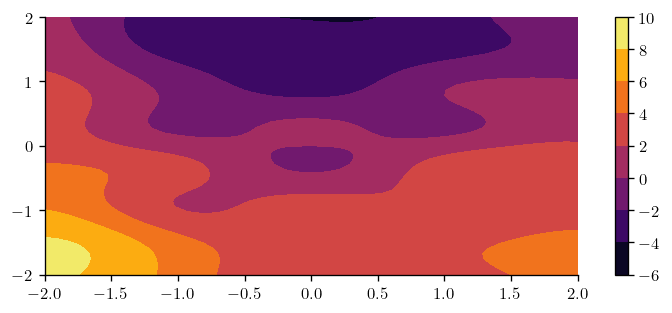

In [16]:
kernel = AdditiveKernel(
    kernels=[OrthogonalRBF(active_dims=[0], lengthscale=jnp.array(0.1)), OrthogonalRBF(active_dims=[1], lengthscale=jnp.array(0.1))],
    interaction_variances=jnp.array([1.0,1.0, 1.0]), 
    max_interaction_depth=2,
)
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=noise)#.replace_trainable(obs_noise=False)
posterior = AdditivePosterior(prior =prior, likelihood=likelihood)


opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=gpx.objectives.ConjugateMLL(negative=True),
    train_data=D,
)


print(f"variances are {opt_posterior.prior.kernel.interaction_variances}")
print(f"lengthscaels are {[k.lengthscale for k in opt_posterior.prior.kernel.kernels]}")
plt.figure()
plot(opt_posterior.predict(xplot2d, D).mean())

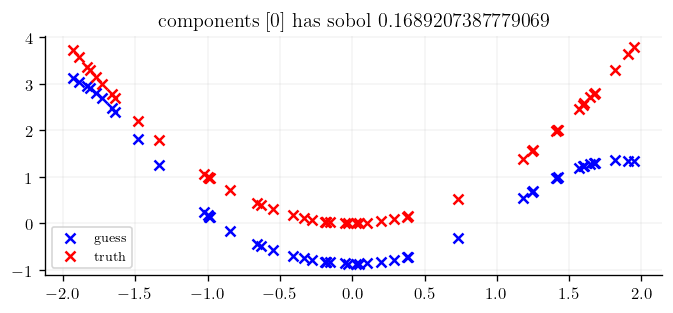

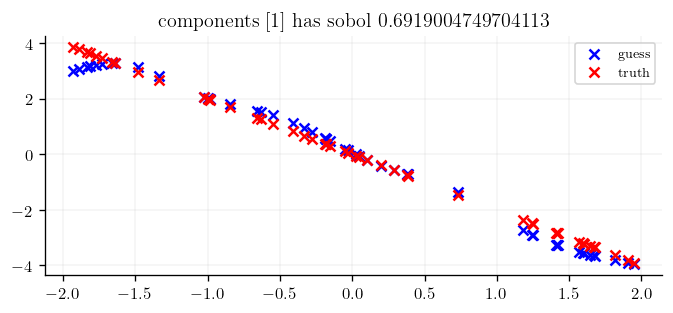

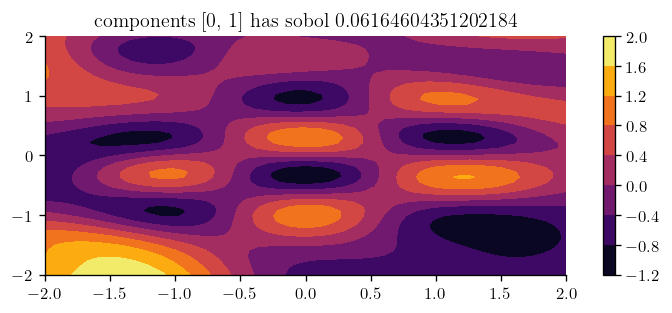

In [17]:

def plot_posterior_with_components(opt_posterior, components):
    plt.figure()
    plt.title(f"components {components} has sobol {opt_posterior.get_sobol_index(D, components)}")
    if len(components)==1:
        plt.scatter(xplot1d[:,components[0]], opt_posterior.predict_additive_component(xplot1d, D, components).mean(), color="blue", label="guess")
        truth = xplot1d[:,components[0]]**2 if components[0]==0 else -2*xplot1d[:,components[0]]
        plt.scatter(xplot1d[:,components[0]], truth, color="red", label="truth")
        plt.legend()
    elif len(components)==2:
        plot(opt_posterior.predict_additive_component(xplot2d, D, components).mean())
    


plot_posterior_with_components(opt_posterior, [0])
plot_posterior_with_components(opt_posterior, [1])
plot_posterior_with_components(opt_posterior, [0,1])